In [2]:
# Improved ResNet-50 for Corn Disease Classification
!pip uninstall charset-normalizer -y
!pip install charset-normalizer --upgrade


Found existing installation: charset-normalizer 3.4.0
Uninstalling charset-normalizer-3.4.0:
  Successfully uninstalled charset-normalizer-3.4.0


## Import Required Libraries

In [3]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2

# For visualization
import cv2
from PIL import Image
import matplotlib.cm as cm

# GradCAM visualization
import tensorflow.keras.backend as K



c:\Users\natha\anaconda3\envs\GPU\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Set Random Seeds

In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


## Define Constants

In [5]:
# Constants
IMG_SIZE = 224  # ResNet-50 input size
BATCH_SIZE = 32
EPOCHS = 100
BASE_LR = 1e-5
MIN_LR = 1e-7
WEIGHT_DECAY = 1e-5
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15



## Define Dataset Paths and Classes

In [10]:
# Define data paths and classes
BASE_DIR = r'C:\Users\natha\Downloads\archive\PlantVillage'  # Update this to your dataset path
CORN_CLASSES = [
    'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Corn_(maize)___healthy'
]

# Map class names to simpler labels
CLASS_MAPPING = {
    'Corn_(maize)___Common_rust_': 'Common Rust',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 'Gray Leaf Spot',
    'Corn_(maize)___Northern_Leaf_Blight': 'Northern Leaf Blight',
    'Corn_(maize)___healthy': 'Healthy'
}



## Define Image Loader Function

In [11]:
# Function to load corn images and their labels
def load_corn_data(base_dir):
    images = []
    labels = []
    paths = []
    
    for class_name in CORN_CLASSES:
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} not found. Skipping.")
            continue
        
        class_label = CLASS_MAPPING[class_name]
        print(f"Loading {class_name} images...")
        
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_dir, img_name)
                paths.append(img_path)
                labels.append(class_label)
    
    return paths, labels



## Load Images and Labels

In [12]:
# Load image paths and labels
image_paths, image_labels = load_corn_data(BASE_DIR)



Loading Corn_(maize)___Common_rust_ images...
Loading Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot images...
Loading Corn_(maize)___Northern_Leaf_Blight images...
Loading Corn_(maize)___healthy images...


## Create DataFrame

In [13]:
# Create a DataFrame for easier data manipulation
df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

print(f"Total number of images: {len(df)}")
print(df['label'].value_counts())



Total number of images: 3852
label
Common Rust             1192
Healthy                 1162
Northern Leaf Blight     985
Gray Leaf Spot           513
Name: count, dtype: int64


## Exploratory Data Analysis

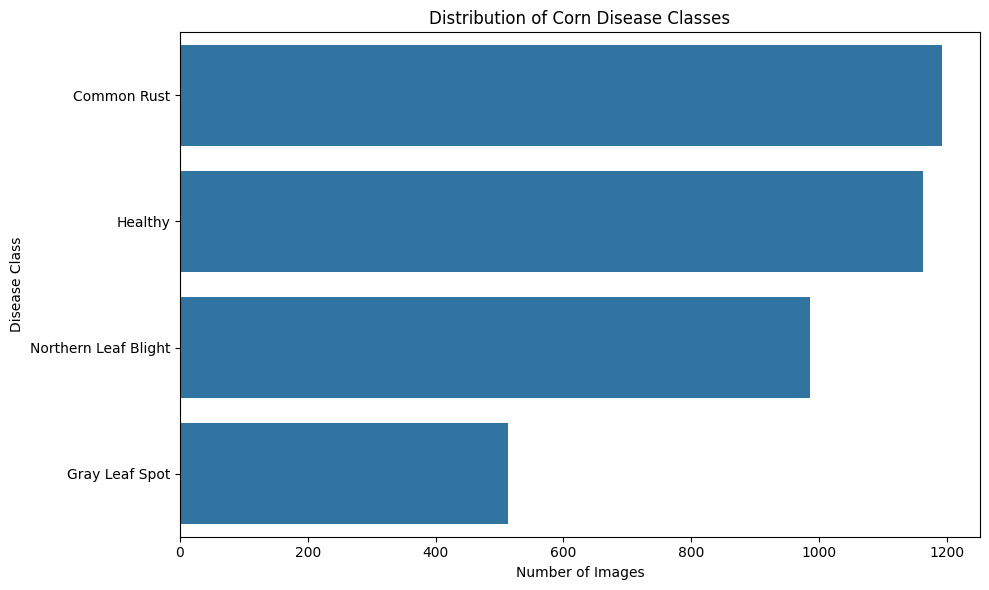

Common Rust: 1192 images (30.94%)
Healthy: 1162 images (30.17%)
Northern Leaf Blight: 985 images (25.57%)
Gray Leaf Spot: 513 images (13.32%)


In [14]:
# Exploratory Data Analysis
def plot_class_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=df['label'], order=df['label'].value_counts().index)
    plt.title('Distribution of Corn Disease Classes')
    plt.xlabel('Number of Images')
    plt.ylabel('Disease Class')
    plt.tight_layout()
    plt.show()
    
    # Print class distribution statistics
    class_counts = df['label'].value_counts()
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images ({count/len(df)*100:.2f}%)")

plot_class_distribution(df)



## Visualize Sample Images

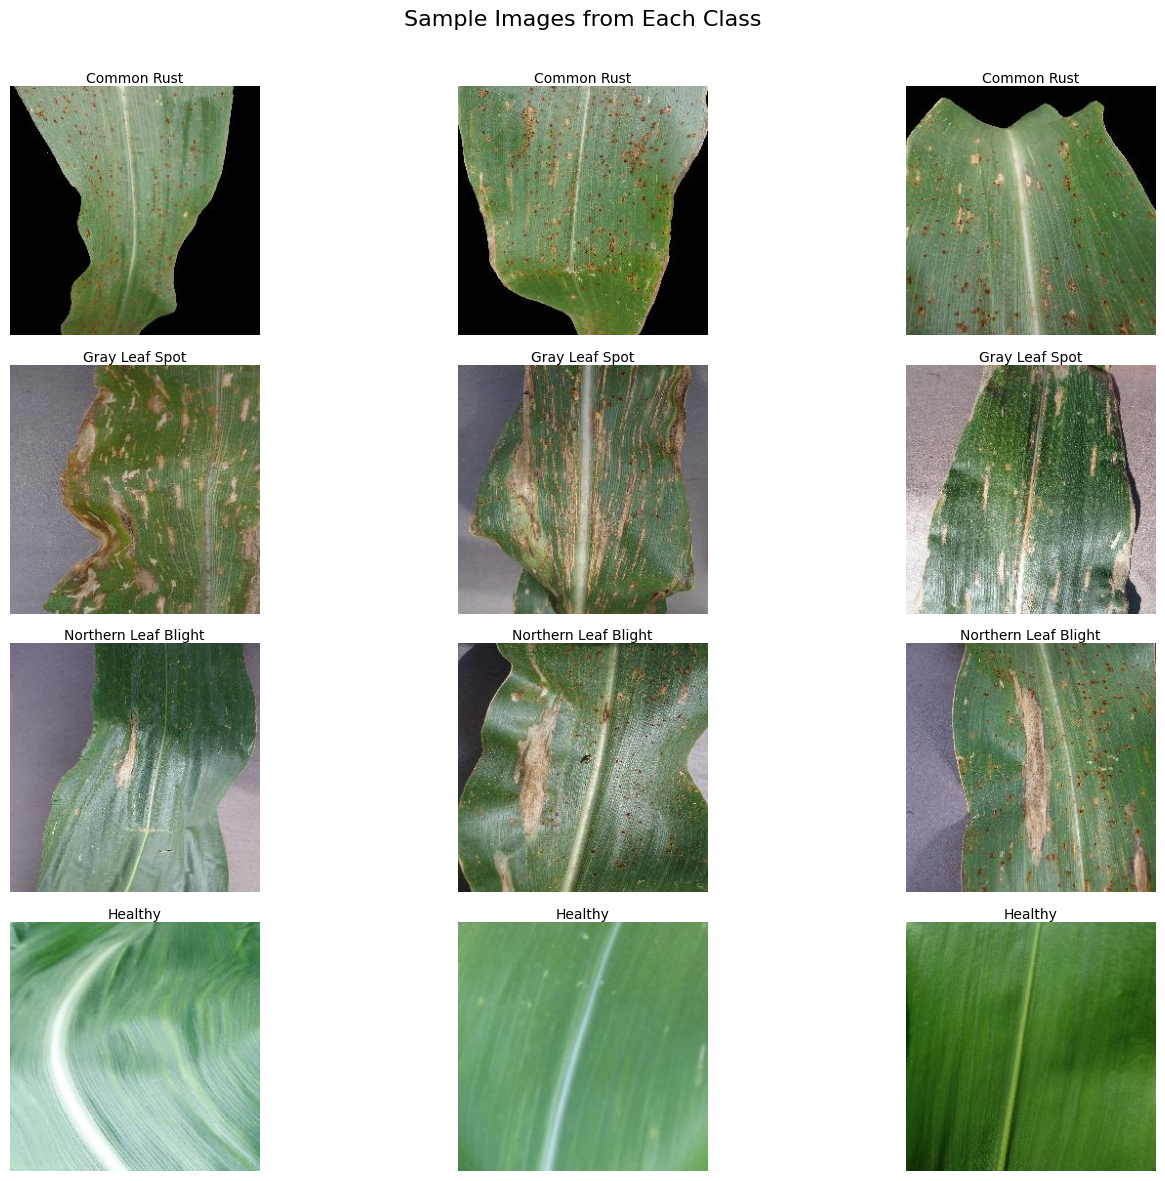

In [15]:
# Visualize sample images
def visualize_sample_images(df, num_samples=3):
    unique_labels = df['label'].unique()
    fig, axes = plt.subplots(len(unique_labels), num_samples, figsize=(15, 12))
    
    for i, label in enumerate(unique_labels):
        # Get random samples for current class
        class_samples = df[df['label'] == label].sample(num_samples)
        
        for j, (_, row) in enumerate(class_samples.iterrows()):
            img = Image.open(row['image_path'])
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            # Show the label below each image
            axes[i, j].set_title(label, fontsize=10, pad=2)
            
            # Optionally, set the row label (Y-axis) only on the first column
            if j == 0:
                axes[i, j].set_ylabel(label, fontsize=12)
    
    plt.suptitle('Sample Images from Each Class', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

visualize_sample_images(df)



## Convert Class Labels

In [16]:
# Convert class labels to numerical indices
label_to_idx = {class_name: idx for idx, class_name in enumerate(sorted(df['label'].unique()))}
idx_to_label = {idx: class_name for class_name, idx in label_to_idx.items()}
df['label_idx'] = df['label'].map(label_to_idx)



## Split Dataset

In [17]:
# Data Splitting
train_df, temp_df = train_test_split(
    df, test_size=VALIDATION_SPLIT + TEST_SPLIT, 
    stratify=df['label'], 
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=TEST_SPLIT/(VALIDATION_SPLIT + TEST_SPLIT),
    stratify=temp_df['label'], 
    random_state=42
)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")



Training set: 2696 images
Validation set: 578 images
Test set: 578 images


## Compute Class Weights

In [18]:
# Calculate class weights for handling imbalance
class_counts = df['label'].value_counts().to_dict()
total_samples = len(df)
class_weights = {
    label_to_idx[class_name]: total_samples / (len(class_counts) * count) 
    for class_name, count in class_counts.items()
}
print("Class weights:", class_weights)



Class weights: {0: 0.8078859060402684, 2: 0.8287435456110155, 3: 0.9776649746192894, 1: 1.8771929824561404}


## Create Data Generators

In [19]:
# Enhanced Data Augmentation
# Training generator with more aggressive augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,           # More rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,             # More shear
    zoom_range=0.3,              # More zoom
    horizontal_flip=True,
    vertical_flip=True,          # Add vertical flips
    brightness_range=[0.8, 1.2], # Brightness variation
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# For validation and test: only preprocessing (no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 2696 validated image filenames belonging to 4 classes.
Found 578 validated image filenames belonging to 4 classes.
Found 578 validated image filenames belonging to 4 classes.


## Define Learning Rate Scheduler

In [20]:
# Create a custom learning rate schedule
def step_decay_schedule(initial_lr, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** (epoch // step_size))
    return schedule

# Create a more advanced ResNet-50 model with progressive unfreezing and regularization
def create_improved_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4, weight_decay=WEIGHT_DECAY):
    # Load pre-trained ResNet-50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False
        
    # Add custom top layers with stronger regularization
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # First Dense layer with increased size and L2 regularization
    x = Dense(1024, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)  # Higher dropout
    
    # Second Dense layer
    x = Dense(512, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(weight_decay))(x)
    
    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Create model
model, base_model = create_improved_model(num_classes=len(label_to_idx))



## Compile Model

In [22]:
# Compile model with lower initial learning rate
model.compile(
    optimizer=Adam(learning_rate=BASE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks for stage 1 training (only training the top layers)
stage1_callbacks = [
    ModelCheckpoint(
        'models/corn_resnet50_stage1_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=MIN_LR,
        verbose=1
    ),
    LearningRateScheduler(step_decay_schedule(BASE_LR, decay_factor=0.75, step_size=10))
]



## Train Stage 1

In [23]:
# Stage 1: Train only the top layers
print("Stage 1: Training only the top layers...")
history_stage1 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=stage1_callbacks,
    class_weight=class_weights,
    verbose=1
)



Stage 1: Training only the top layers...
Epoch 1/30
85/85 [==============================] - ETA: 0s - loss: 1.9210 - accuracy: 0.3757
Epoch 1: val_accuracy improved from -inf to 0.63668, saving model to models\corn_resnet50_stage1_best.h5
85/85 [==============================] - 24s 214ms/step - loss: 1.9210 - accuracy: 0.3757 - val_loss: 0.8856 - val_accuracy: 0.6367 - lr: 1.0000e-05
Epoch 2/30
85/85 [==============================] - ETA: 0s - loss: 1.2995 - accuracy: 0.5783
Epoch 2: val_accuracy improved from 0.63668 to 0.82007, saving model to models\corn_resnet50_stage1_best.h5
85/85 [==============================] - 20s 237ms/step - loss: 1.2995 - accuracy: 0.5783 - val_loss: 0.5066 - val_accuracy: 0.8201 - lr: 1.0000e-05
Epoch 3/30
85/85 [==============================] - ETA: 0s - loss: 1.0021 - accuracy: 0.6699
Epoch 3: val_accuracy improved from 0.82007 to 0.87024, saving model to models\corn_resnet50_stage1_best.h5
85/85 [==============================] - 21s 250ms/step - 

## Train Stage 2

In [29]:
# Stage 2: Unfreeze and fine-tune the last block of ResNet-50
print("Stage 2: Fine-tuning the last ResNet block...")
# Unfreeze the last block (layers of conv5)
for layer in base_model.layers:
    if "conv5" in layer.name or "bn5" in layer.name:
        layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=BASE_LR/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

stage2_callbacks = [
    ModelCheckpoint(
        'models/corn_resnet50_stage2_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=MIN_LR,
        verbose=1
    ),
    LearningRateScheduler(step_decay_schedule(BASE_LR/10, decay_factor=0.75, step_size=5))
]

# Train stage 2
history_stage2 = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=stage2_callbacks,
    class_weight=class_weights,
    verbose=1,
    initial_epoch=len(history_stage1.history['loss'])
)



Stage 2: Fine-tuning the last ResNet block...
Epoch 31/50
85/85 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.8101
Epoch 31: val_accuracy improved from -inf to 0.94637, saving model to models\corn_resnet50_stage2_best.h5
85/85 [==============================] - 25s 246ms/step - loss: 0.5732 - accuracy: 0.8101 - val_loss: 0.1565 - val_accuracy: 0.9464 - lr: 1.7798e-07
Epoch 32/50
85/85 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.8257
Epoch 32: val_accuracy did not improve from 0.94637
85/85 [==============================] - 20s 239ms/step - loss: 0.5764 - accuracy: 0.8257 - val_loss: 0.1912 - val_accuracy: 0.9446 - lr: 1.7798e-07
Epoch 33/50
85/85 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.8290
Epoch 33: val_accuracy did not improve from 0.94637
85/85 [==============================] - 24s 287ms/step - loss: 0.5793 - accuracy: 0.8290 - val_loss: 0.2047 - val_accuracy: 0.9412 - lr: 1.7798e-07
Epoch 34/50


## Train Stage 3

In [30]:
# Stage 3: Unfreeze and fine-tune even more layers
print("Stage 3: Fine-tuning more ResNet layers...")
# Unfreeze more layers (including conv4)
for layer in base_model.layers:
    if "conv4" in layer.name or "bn4" in layer.name or "conv5" in layer.name or "bn5" in layer.name:
        layer.trainable = True

# Recompile with an even lower learning rate
model.compile(
    optimizer=Adam(learning_rate=BASE_LR/100),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

stage3_callbacks = [
    ModelCheckpoint(
        'models/corn_resnet50_final_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=8,
        min_lr=MIN_LR,
        verbose=1
    )
]

# Train stage 3
history_stage3 = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=stage3_callbacks,
    class_weight=class_weights,
    verbose=1,
    initial_epoch=len(history_stage1.history['loss']) + len(history_stage2.history['loss'])
)



Stage 3: Fine-tuning more ResNet layers...
Epoch 47/100
85/85 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.8216
Epoch 47: val_accuracy improved from -inf to 0.94810, saving model to models\corn_resnet50_final_best.h5
85/85 [==============================] - 25s 248ms/step - loss: 0.5782 - accuracy: 0.8216 - val_loss: 0.1904 - val_accuracy: 0.9481 - lr: 1.0000e-07
Epoch 48/100
85/85 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.8260
Epoch 48: val_accuracy did not improve from 0.94810
85/85 [==============================] - 20s 233ms/step - loss: 0.5658 - accuracy: 0.8260 - val_loss: 0.2025 - val_accuracy: 0.9429 - lr: 1.0000e-07
Epoch 49/100
85/85 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.8501
Epoch 49: val_accuracy did not improve from 0.94810
85/85 [==============================] - 20s 229ms/step - loss: 0.5275 - accuracy: 0.8501 - val_loss: 0.2062 - val_accuracy: 0.9429 - lr: 1.0000e-07
Epoch 50/100


## Combine Training History

In [31]:
# Combine all history objects
history_combined = {
    'loss': history_stage1.history['loss'] + history_stage2.history['loss'] + history_stage3.history['loss'],
    'accuracy': history_stage1.history['accuracy'] + history_stage2.history['accuracy'] + history_stage3.history['accuracy'],
    'val_loss': history_stage1.history['val_loss'] + history_stage2.history['val_loss'] + history_stage3.history['val_loss'],
    'val_accuracy': history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy'] + history_stage3.history['val_accuracy']
}



## Plot Training History

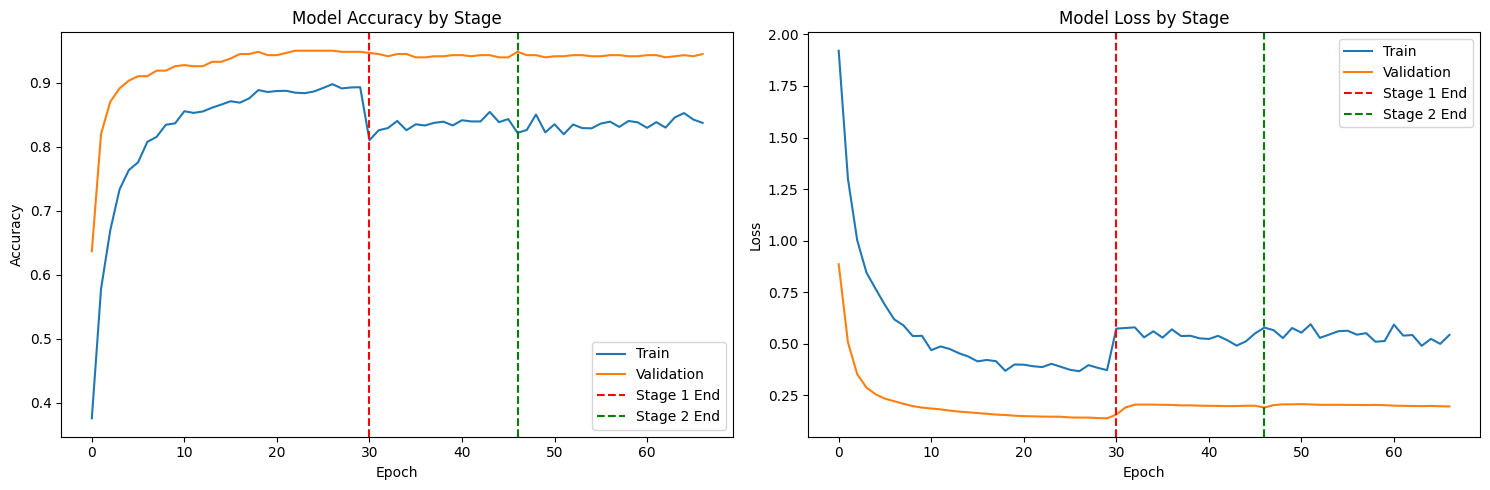

In [32]:
# Plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.axvline(x=len(history_stage1.history['loss']), color='r', linestyle='--')
    plt.axvline(x=len(history_stage1.history['loss']) + len(history_stage2.history['loss']), color='g', linestyle='--')
    plt.title('Model Accuracy by Stage')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Stage 1 End', 'Stage 2 End'], loc='lower right')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.axvline(x=len(history_stage1.history['loss']), color='r', linestyle='--')
    plt.axvline(x=len(history_stage1.history['loss']) + len(history_stage2.history['loss']), color='g', linestyle='--')
    plt.title('Model Loss by Stage')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Stage 1 End', 'Stage 2 End'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_combined)



## Evaluate on Test Data

In [33]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")



19/19 [==============================] - 1s 58ms/step - loss: 0.1570 - accuracy: 0.9498
Test Accuracy: 0.9498
Test Loss: 0.1570


## Generate Metrics

In [34]:
# Get predictions for detailed metrics
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Generate classification report
class_names = list(idx_to_label.values())
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))



19/19 [==============================] - 2s 57ms/step

Classification Report:

                      precision    recall  f1-score   support

         Common Rust       1.00      1.00      1.00       179
      Gray Leaf Spot       0.85      0.79      0.82        77
             Healthy       1.00      0.99      0.99       175
Northern Leaf Blight       0.88      0.93      0.90       147

            accuracy                           0.95       578
           macro avg       0.93      0.93      0.93       578
        weighted avg       0.95      0.95      0.95       578



## Plot Confusion Matrix

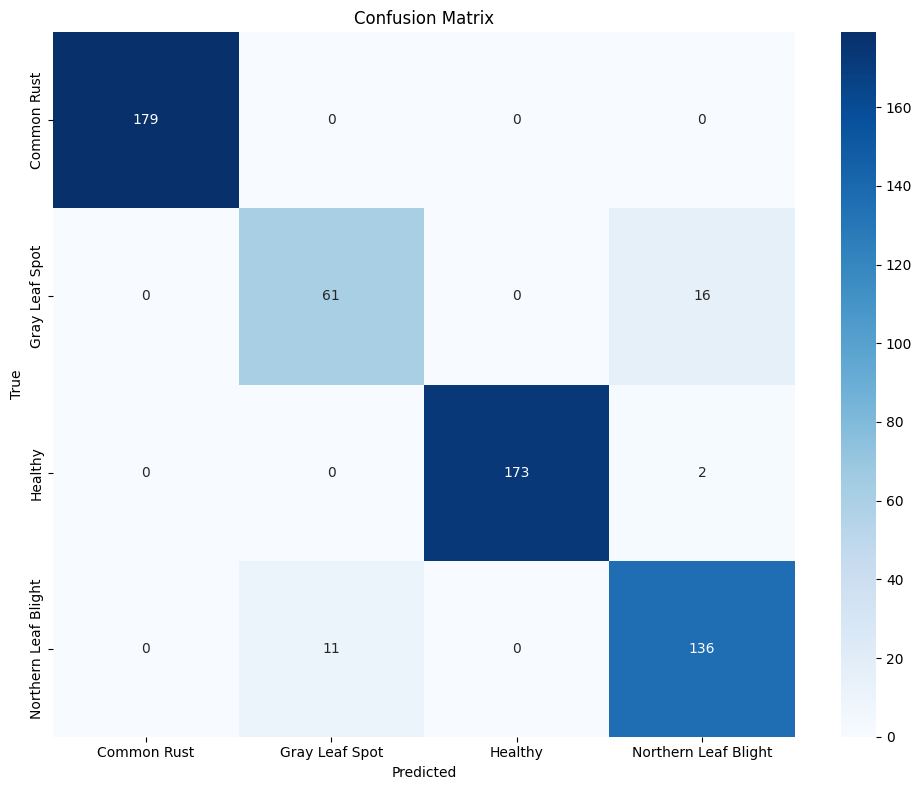

In [35]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()



## Define GradCAM Functions

In [ ]:
def simple_corn_disease_visualization(model, test_df):
    """
    Very simple visualization of a single image prediction
    """
    print("Starting simple visualization...")
    
    # Just take the first image from the test set
    if len(test_df) == 0:
        print("Error: Test dataset is empty")
        return
        
    sample_row = test_df.iloc[0]
    img_path = sample_row['image_path']
    true_label = sample_row['label']
    
    print(f"Processing image: {img_path}")
    print(f"True label: {true_label}")
    
    # Check if the image exists
    if not os.path.exists(img_path):
        print(f"Error: Image file not found: {img_path}")
        return
    
    try:
        # Load and display the original image
        img = plt.imread(img_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Corn Leaf - Class: {true_label}")
        plt.axis('off')
        print("Displaying image...")
        plt.show()
        print("After plt.show()")
        
        # Process for prediction
        processed_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = tf.keras.preprocessing.image.img_to_array(processed_img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        
        # Make prediction
        print("Making prediction...")
        preds = model.predict(img_array, verbose=1)
        pred_class_idx = np.argmax(preds[0])
        pred_class_name = idx_to_label[pred_class_idx]
        confidence = preds[0][pred_class_idx] * 100
        
        print(f"Prediction: {pred_class_name}")
        print(f"Confidence: {confidence:.2f}%")
        
        # Create a bar chart of the predictions
        plt.figure(figsize=(10, 5))
        plt.bar(list(idx_to_label.values()), preds[0] * 100)
        plt.xlabel('Disease Class')
        plt.ylabel('Confidence (%)')
        plt.title(f'Prediction: {pred_class_name} ({confidence:.2f}%)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        print("Displaying prediction chart...")
        plt.show()
        print("Visualization complete")
        
    except Exception as e:
        print(f"Error in visualization: {e}")
        import traceback
        traceback.print_exc()

# Try the simple visualization
print("Calling simple visualization function")
simple_corn_disease_visualization(model, test_df)
print("Function call completed")

## Visualize with GradCAM

Testing visualization on image: C:\Users\natha\Downloads\archive\PlantVillage\Corn_(maize)___Northern_Leaf_Blight\3513a96e-7db5-4a2b-9dd8-79847c92e75b___RS_NLB 4045 copy 2.jpg
Model structure:
  Layer 0: input_1 (InputLayer)
  Layer 1: conv1_pad (ZeroPadding2D)
  Layer 2: conv1_conv (Conv2D)
  Layer 3: conv1_bn (BatchNormalization)
  Layer 4: conv1_relu (Activation)
  Layer 5: pool1_pad (ZeroPadding2D)
  Layer 6: pool1_pool (MaxPooling2D)
  Layer 7: conv2_block1_1_conv (Conv2D)
  Layer 8: conv2_block1_1_bn (BatchNormalization)
  Layer 9: conv2_block1_1_relu (Activation)
  Layer 10: conv2_block1_2_conv (Conv2D)
  Layer 11: conv2_block1_2_bn (BatchNormalization)
  Layer 12: conv2_block1_2_relu (Activation)
  Layer 13: conv2_block1_0_conv (Conv2D)
  Layer 14: conv2_block1_3_conv (Conv2D)
  Layer 15: conv2_block1_0_bn (BatchNormalization)
  Layer 16: conv2_block1_3_bn (BatchNormalization)
  Layer 17: conv2_block1_add (Add)
  Layer 18: conv2_block1_out (Activation)
  Layer 19: conv2_block2_

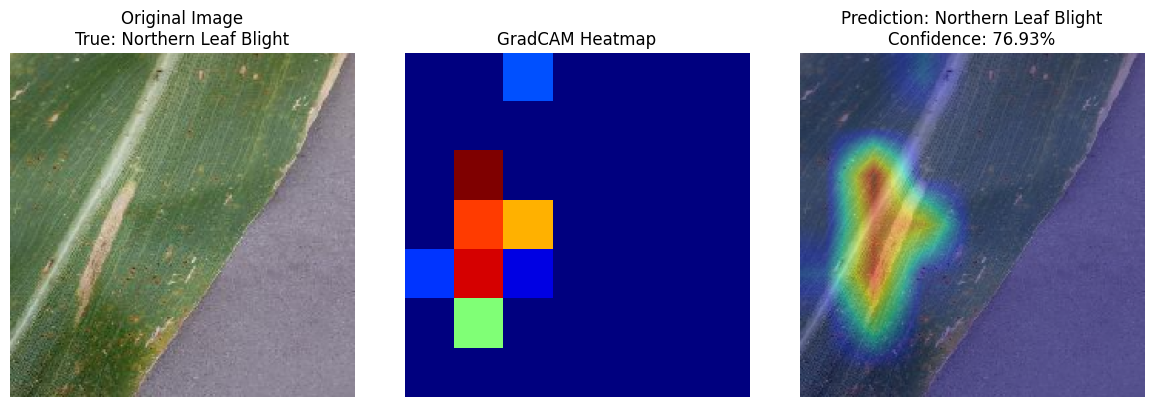

Visualization saved to gradcam_output.png


('Northern Leaf Blight', 76.9269049167633)

In [48]:
def visualize_single_prediction(model, img_path, true_label=None):
    """
    Visualize a prediction for a single image with GradCAM
    """
    # First, print the model summary to understand its structure
    print("Model structure:")
    for i, layer in enumerate(model.layers):
        print(f"  Layer {i}: {layer.name} ({type(layer).__name__})")
    
    # Find a suitable convolutional layer for GradCAM
    last_conv_layer_name = None
    
    # Option 1: Look for the last conv layer directly in the model
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            print(f"Found Conv2D layer: {last_conv_layer_name}")
            break
    
    # Option 2: If the model uses a functional or sequential base model
    if last_conv_layer_name is None:
        for layer in model.layers:
            if hasattr(layer, 'layers'):  # Check if this layer contains other layers
                for sublayer in reversed(layer.layers):
                    if isinstance(sublayer, tf.keras.layers.Conv2D):
                        last_conv_layer_name = sublayer.name
                        print(f"Found Conv2D sublayer: {last_conv_layer_name}")
                        break
                if last_conv_layer_name:
                    break
    
    # Option 3: Use a common layer name from ResNet-50
    if last_conv_layer_name is None:
        common_layer_names = ['conv5_block3_out', 'conv5_block3_3_conv', 'conv5_3']
        for name in common_layer_names:
            try:
                layer = model.get_layer(name)
                last_conv_layer_name = name
                print(f"Using common ResNet layer: {last_conv_layer_name}")
                break
            except:
                continue
    
    if last_conv_layer_name is None:
        print("No suitable convolutional layer found for GradCAM")
        # Display the image and prediction without GradCAM
        display_prediction_only(model, img_path, true_label)
        return
    
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    display_img = img_array.copy() 
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Get prediction
    preds = model.predict(img_array, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_label = idx_to_label[pred_idx]
    confidence = preds[0][pred_idx] * 100
    
    try:
        # Generate heatmap using a simple approach
        # Create a gradient model
        grad_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )
        
        # Get the feature map and prediction
        with tf.GradientTape() as tape:
            conv_output, predictions = grad_model(img_array)
            pred_index = tf.argmax(predictions[0])
            class_output = predictions[:, pred_index]
            
        # Gradient of top predicted class with respect to conv output
        grads = tape.gradient(class_output, conv_output)
        
        # Global average pooling of gradients
        weights = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Create the heatmap using numpy to avoid tensor assignment issues
        conv_output = conv_output.numpy()[0]
        weights = weights.numpy()
        
        heatmap = np.zeros(conv_output.shape[0:2])
        for i, w in enumerate(weights):
            heatmap += w * conv_output[:, :, i]
            
        # Normalize heatmap
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        
        # Display the results
        plt.figure(figsize=(12, 4))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(display_img.astype('uint8'))
        title = f"Original Image"
        if true_label:
            title += f"\nTrue: {true_label}"
        plt.title(title)
        plt.axis('off')
        
        # Heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("GradCAM Heatmap")
        plt.axis('off')
        
        # Overlay
        plt.subplot(1, 3, 3)
        # Resize heatmap to match image dimensions
        heatmap_resized = cv2.resize(heatmap, (display_img.shape[1], display_img.shape[0]))
        heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])
        
        # Convert display_img to uint8 if it's not already
        if display_img.dtype != np.uint8:
            display_img = np.uint8(display_img)
            
        superimposed = cv2.addWeighted(display_img, 0.6, heatmap_rgb, 0.4, 0)
        plt.imshow(superimposed)
        plt.title(f"Prediction: {pred_label}\nConfidence: {confidence:.2f}%")
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('gradcam_output.png')
        plt.show()
        print(f"Visualization saved to gradcam_output.png")
        
    except Exception as e:
        print(f"Error generating GradCAM: {e}")
        import traceback
        traceback.print_exc()
        
        # Fall back to just showing the prediction
        display_prediction_only(model, img_path, true_label)
    
    return pred_label, confidence

def display_prediction_only(model, img_path, true_label=None):
    """
    Display image and prediction without GradCAM
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    display_img = img_array.copy() 
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Get prediction
    preds = model.predict(img_array, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_label = idx_to_label[pred_idx]
    confidence = preds[0][pred_idx] * 100
    
    # Display the results
    plt.figure(figsize=(10, 6))
    plt.imshow(display_img.astype('uint8'))
    
    title = f"Prediction: {pred_label}\nConfidence: {confidence:.2f}%"
    if true_label:
        title = f"True: {true_label}\n" + title
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('prediction_output.png')
    plt.show()
    print(f"Simple visualization saved to prediction_output.png")

# Test with a single image
sample_img_path = test_df.iloc[0]['image_path']
true_label = test_df.iloc[0]['label'] 
print(f"Testing visualization on image: {sample_img_path}")
visualize_single_prediction(model, sample_img_path, true_label)

Visualizing a random image from the test set...
Randomly selected image index 332: C:\Users\natha\Downloads\archive\PlantVillage\Corn_(maize)___healthy\c9272300-fc37-4b47-b09f-6a0f4e59f1bf___R.S_HL 7887 copy.jpg
Model structure:
  Layer 0: input_1 (InputLayer)
  Layer 1: conv1_pad (ZeroPadding2D)
  Layer 2: conv1_conv (Conv2D)
  Layer 3: conv1_bn (BatchNormalization)
  Layer 4: conv1_relu (Activation)
  Layer 5: pool1_pad (ZeroPadding2D)
  Layer 6: pool1_pool (MaxPooling2D)
  Layer 7: conv2_block1_1_conv (Conv2D)
  Layer 8: conv2_block1_1_bn (BatchNormalization)
  Layer 9: conv2_block1_1_relu (Activation)
  Layer 10: conv2_block1_2_conv (Conv2D)
  Layer 11: conv2_block1_2_bn (BatchNormalization)
  Layer 12: conv2_block1_2_relu (Activation)
  Layer 13: conv2_block1_0_conv (Conv2D)
  Layer 14: conv2_block1_3_conv (Conv2D)
  Layer 15: conv2_block1_0_bn (BatchNormalization)
  Layer 16: conv2_block1_3_bn (BatchNormalization)
  Layer 17: conv2_block1_add (Add)
  Layer 18: conv2_block1_out (A

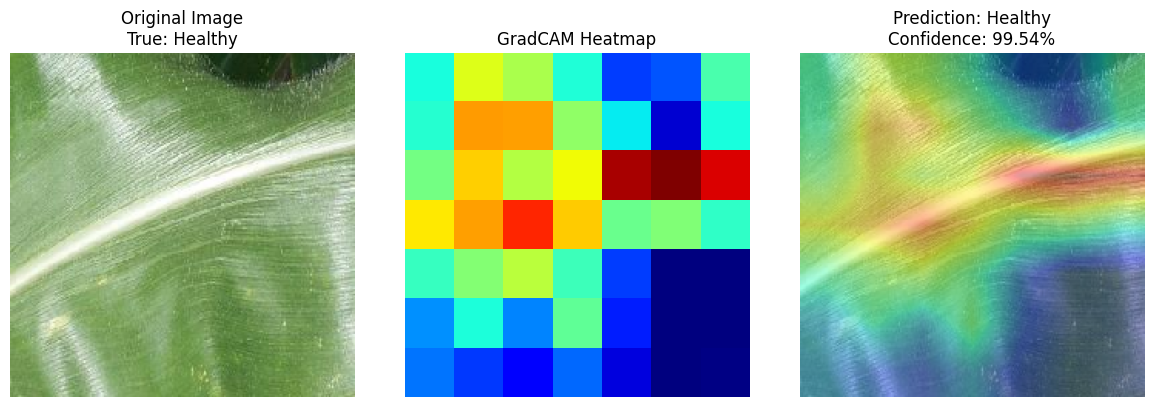

Visualization saved to gradcam_Healthy_1747481163.png


In [51]:
def visualize_single_prediction(model, img_path=None, true_label=None, random_selection=True, excluded_indices=None):
    """
    Visualize a prediction for a single image with GradCAM
    
    Parameters:
    - model: The trained model
    - img_path: Optional specific image path (ignored if random_selection=True)
    - true_label: Optional true label (auto-detected if random_selection=True)
    - random_selection: Whether to randomly select an image from test_df
    - excluded_indices: List of indices to exclude from random selection
    """
    # For random selection, choose an image from test_df
    if random_selection:
        # Get available indices (excluding any that should be skipped)
        available_indices = list(range(len(test_df)))
        if excluded_indices:
            available_indices = [i for i in available_indices if i not in excluded_indices]
            
        if not available_indices:
            print("No more images available to visualize")
            return None, None
            
        # Select a random index
        random_idx = np.random.choice(available_indices)
        img_path = test_df.iloc[random_idx]['image_path']
        true_label = test_df.iloc[random_idx]['label']
        print(f"Randomly selected image index {random_idx}: {img_path}")
    
    # First, print the model summary to understand its structure
    print("Model structure:")
    for i, layer in enumerate(model.layers):
        print(f"  Layer {i}: {layer.name} ({type(layer).__name__})")
    
    # Find a suitable convolutional layer for GradCAM
    last_conv_layer_name = None
    
    # Option 1: Look for the last conv layer directly in the model
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            print(f"Found Conv2D layer: {last_conv_layer_name}")
            break
    
    # Option 2: If the model uses a functional or sequential base model
    if last_conv_layer_name is None:
        for layer in model.layers:
            if hasattr(layer, 'layers'):  # Check if this layer contains other layers
                for sublayer in reversed(layer.layers):
                    if isinstance(sublayer, tf.keras.layers.Conv2D):
                        last_conv_layer_name = sublayer.name
                        print(f"Found Conv2D sublayer: {last_conv_layer_name}")
                        break
                if last_conv_layer_name:
                    break
    
    # Option 3: Use a common layer name from ResNet-50
    if last_conv_layer_name is None:
        common_layer_names = ['conv5_block3_out', 'conv5_block3_3_conv', 'conv5_3']
        for name in common_layer_names:
            try:
                layer = model.get_layer(name)
                last_conv_layer_name = name
                print(f"Using common ResNet layer: {last_conv_layer_name}")
                break
            except:
                continue
    
    if last_conv_layer_name is None:
        print("No suitable convolutional layer found for GradCAM")
        # Display the image and prediction without GradCAM
        display_prediction_only(model, img_path, true_label)
        return
    
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    display_img = img_array.copy() 
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Get prediction
    preds = model.predict(img_array, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_label = idx_to_label[pred_idx]
    confidence = preds[0][pred_idx] * 100
    
    try:
        # Generate heatmap using a simple approach
        # Create a gradient model
        grad_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )
        
        # Get the feature map and prediction
        with tf.GradientTape() as tape:
            conv_output, predictions = grad_model(img_array)
            pred_index = tf.argmax(predictions[0])
            class_output = predictions[:, pred_index]
            
        # Gradient of top predicted class with respect to conv output
        grads = tape.gradient(class_output, conv_output)
        
        # Global average pooling of gradients
        weights = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Create the heatmap using numpy to avoid tensor assignment issues
        conv_output = conv_output.numpy()[0]
        weights = weights.numpy()
        
        heatmap = np.zeros(conv_output.shape[0:2])
        for i, w in enumerate(weights):
            heatmap += w * conv_output[:, :, i]
            
        # Normalize heatmap
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        
        # Display the results
        plt.figure(figsize=(12, 4))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(display_img.astype('uint8'))
        title = f"Original Image"
        if true_label:
            title += f"\nTrue: {true_label}"
        plt.title(title)
        plt.axis('off')
        
        # Heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("GradCAM Heatmap")
        plt.axis('off')
        
        # Overlay
        plt.subplot(1, 3, 3)
        # Resize heatmap to match image dimensions
        heatmap_resized = cv2.resize(heatmap, (display_img.shape[1], display_img.shape[0]))
        heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])
        
        # Convert display_img to uint8 if it's not already
        if display_img.dtype != np.uint8:
            display_img = np.uint8(display_img)
            
        superimposed = cv2.addWeighted(display_img, 0.6, heatmap_rgb, 0.4, 0)
        plt.imshow(superimposed)
        plt.title(f"Prediction: {pred_label}\nConfidence: {confidence:.2f}%")
        plt.axis('off')
        
        plt.tight_layout()
        
        # Save with a unique filename based on class and timestamp
        import time
        timestamp = int(time.time())
        filename = f"gradcam_{pred_label.replace(' ', '_')}_{timestamp}.png"
        plt.savefig(filename)
        plt.show()
        print(f"Visualization saved to {filename}")
        
    except Exception as e:
        print(f"Error generating GradCAM: {e}")
        import traceback
        traceback.print_exc()
        
        # Fall back to just showing the prediction
        display_prediction_only(model, img_path, true_label)
    
    return pred_label, confidence

def display_prediction_only(model, img_path, true_label=None):
    """
    Display image and prediction without GradCAM
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    display_img = img_array.copy() 
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Get prediction
    preds = model.predict(img_array, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_label = idx_to_label[pred_idx]
    confidence = preds[0][pred_idx] * 100
    
    # Display the results
    plt.figure(figsize=(10, 6))
    plt.imshow(display_img.astype('uint8'))
    
    title = f"Prediction: {pred_label}\nConfidence: {confidence:.2f}%"
    if true_label:
        title = f"True: {true_label}\n" + title
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    
    # Save with a unique filename
    import time
    timestamp = int(time.time())
    filename = f"prediction_{pred_label.replace(' ', '_')}_{timestamp}.png"
    plt.savefig(filename)
    plt.show()
    print(f"Simple visualization saved to {filename}")

# Keep track of already visualized images
visualized_indices = []

# Function to analyze a new random image
def analyze_random_image():
    global visualized_indices
    visualize_single_prediction(model, random_selection=True, excluded_indices=visualized_indices)
    # Add the newly visualized index to our tracking list
    if len(visualized_indices) < len(test_df):
        new_idx = np.random.choice([i for i in range(len(test_df)) if i not in visualized_indices])
        visualized_indices.append(new_idx)

# Call this function to visualize a random image
print("Visualizing a random image from the test set...")
analyze_random_image()

## Analyze Difficult Cases


Analyzing 3 most confident misclassifications:


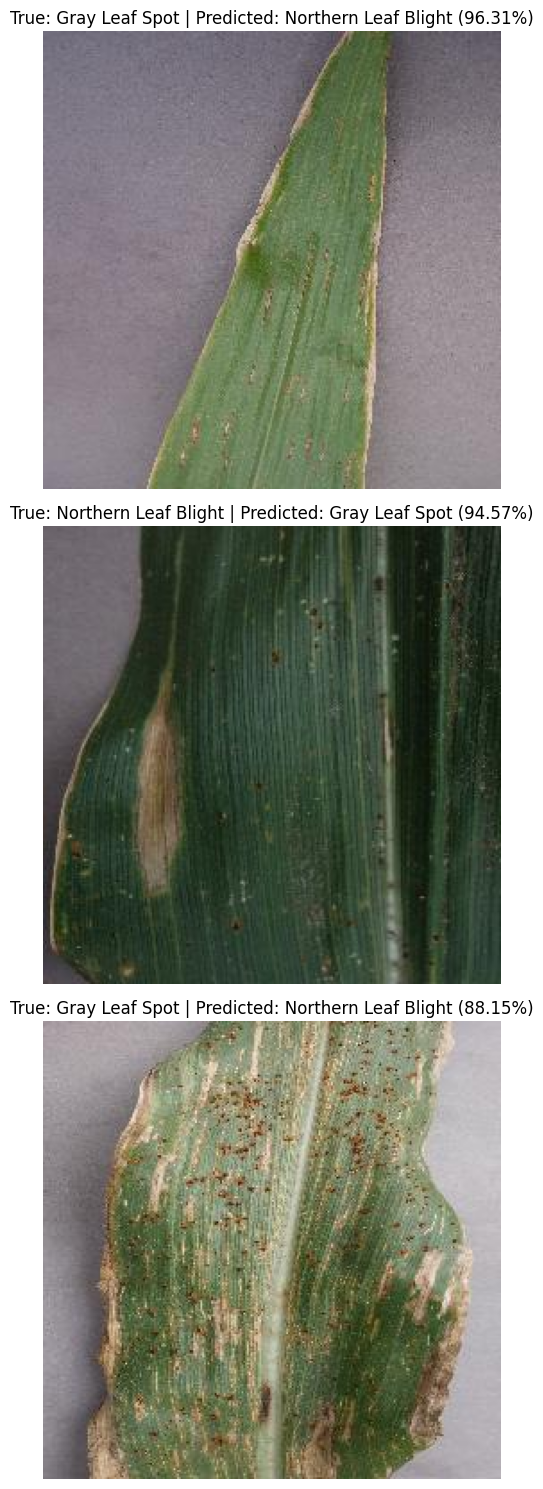


Error rate by class:
Common Rust: 0/179 (0.00%)
Gray Leaf Spot: 16/77 (20.78%)
Healthy: 2/175 (1.14%)
Northern Leaf Blight: 11/147 (7.48%)

Common confusion patterns:
True: Gray Leaf Spot → Predicted: Northern Leaf Blight: 16 instances
True: Northern Leaf Blight → Predicted: Gray Leaf Spot: 11 instances
True: Healthy → Predicted: Northern Leaf Blight: 2 instances


In [52]:
# Function to identify and analyze challenging cases
def analyze_difficult_cases(model, test_df, num_samples=3):
    # Preprocess and predict on all test images
    all_probs = []
    all_preds = []
    all_true = []
    
    for idx, row in test_df.iterrows():
        img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=(IMG_SIZE, IMG_SIZE))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        
        # Make prediction
        probs = model.predict(img_array, verbose=0)
        pred_idx = np.argmax(probs[0])
        
        all_probs.append(probs[0])
        all_preds.append(pred_idx)
        all_true.append(label_to_idx[row['label']])
    
    # Convert to numpy arrays
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_true = np.array(all_true)
    
    # Identify misclassified samples
    misclassified = all_preds != all_true
    misclassified_indices = np.where(misclassified)[0]
    
    # Calculate confidence for misclassified samples
    confidences = [all_probs[i, all_preds[i]] for i in misclassified_indices]
    
    # Sort by confidence (highest first)
    sorted_indices = np.argsort(-np.array(confidences))
    most_confident_errors = [misclassified_indices[i] for i in sorted_indices[:num_samples]]
    
    # Display the most confident misclassifications
    print(f"\nAnalyzing {num_samples} most confident misclassifications:")
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 5*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for i, idx in enumerate(most_confident_errors):
        img_path = test_df.iloc[idx]['image_path']
        true_label = test_df.iloc[idx]['label']
        pred_label = idx_to_label[all_preds[idx]]
        confidence = all_probs[idx, all_preds[idx]] * 100
        
        # Display the image
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label} | Predicted: {pred_label} ({confidence:.2f}%)")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Count misclassifications by class
    true_classes_misclassified = [idx_to_label[all_true[i]] for i in misclassified_indices]
    misclass_counts = Counter(true_classes_misclassified)
    
    # Calculate error rate by class
    print("\nError rate by class:")
    for class_name in sorted(idx_to_label.values()):
        class_indices = [i for i, label in enumerate(test_df['label']) if label == class_name]
        class_errors = sum(1 for i in class_indices if i in misclassified_indices)
        print(f"{class_name}: {class_errors}/{len(class_indices)} ({class_errors/len(class_indices)*100:.2f}%)")
    
    # Analyze common confusion patterns
    print("\nCommon confusion patterns:")
    confusion_pairs = []
    for i in misclassified_indices:
        true_cls = idx_to_label[all_true[i]]
        pred_cls = idx_to_label[all_preds[i]]
        confusion_pairs.append((true_cls, pred_cls))
    
    common_confusions = Counter(confusion_pairs).most_common(5)
    for (true_cls, pred_cls), count in common_confusions:
        print(f"True: {true_cls} → Predicted: {pred_cls}: {count} instances")

# Analyze difficult cases
analyze_difficult_cases(model, test_df)



## Inference on New Images

1/1 [==============================] - 0s 19ms/step


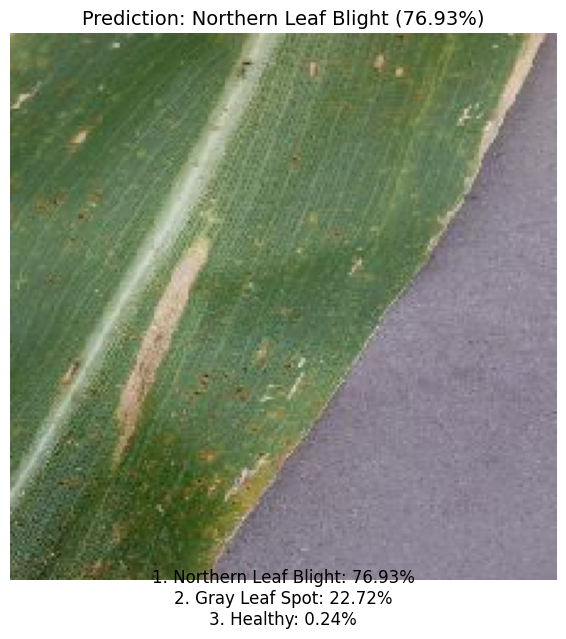

In [56]:
# Create a function for inference on new images
def predict_corn_disease(model, img_path, class_names):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Make prediction
    preds = model.predict(img_array)
    top_indices = np.argsort(preds[0])[::-1][:3]  # Get top 3 predictions
    
    # Prepare results
    results = []
    for idx in top_indices:
        class_name = class_names[idx]
        confidence = preds[0][idx] * 100
        results.append((class_name, confidence))
    
    # Display image and predictions
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    
    # Create prediction text
    title = f"Prediction: {results[0][0]} ({results[0][1]:.2f}%)"
    plt.title(title, fontsize=14)
    
    # Show top 3 predictions
    prediction_text = "\n".join([f"{i+1}. {class_name}: {confidence:.2f}%" 
                              for i, (class_name, confidence) in enumerate(results)])
    plt.figtext(0.5, -0.05, prediction_text, ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Test prediction function on sample images
sample_path = test_df.iloc[0]['image_path']
predict_corn_disease(model, sample_path, list(idx_to_label.values()))

# Model Ensemble (Optional - for even better accuracy)
def create_ensemble_models(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4, num_models=3):
    models = []
    
    for i in range(num_models):
        # Create model with different random initializations
        model, _ = create_improved_model(input_shape, num_classes)
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=BASE_LR),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Print model summary (only once)
        if i == 0:
            model.summary()
        
        models.append(model)
    
    return models

# Function to train ensemble models
def train_ensemble(models, train_generator, val_generator, class_weights, epochs=30):
    trained_models = []
    
    for i, model in enumerate(models):
        print(f"\nTraining model {i+1}/{len(models)}...")
        
        # Define callbacks for this model
        callbacks = [
            ModelCheckpoint(
                f'models/ensemble_model_{i+1}_best.h5',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=MIN_LR,
                verbose=1
            )
        ]
        
        # Train model
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        trained_models.append(model)
    
    return trained_models

# Function to make ensemble predictions
def ensemble_predict(models, img_array):
    # Get predictions from all models
    all_preds = [model.predict(img_array) for model in models]
    
    # Average predictions
    avg_preds = np.mean(all_preds, axis=0)
    
    return avg_preds



Analyzing random image (index 83): C:\Users\natha\Downloads\archive\PlantVillage\Corn_(maize)___healthy\466155e6-ef86-4024-9c0a-de7ca09a1d07___R.S_HL 7986 copy.jpg
True label: Healthy
Using single model prediction


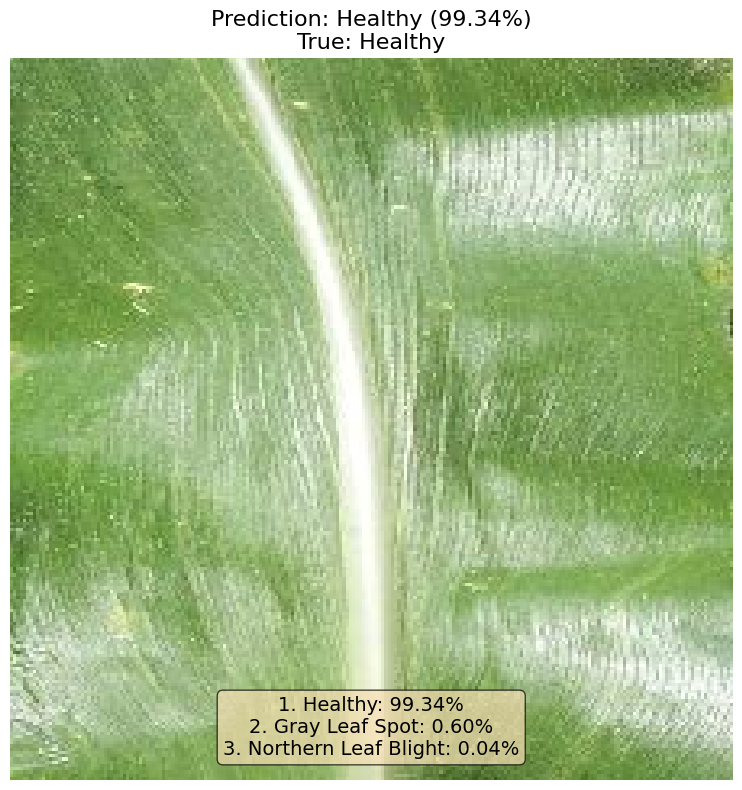

Model structure:
  Layer 0: input_1 (InputLayer)
  Layer 1: conv1_pad (ZeroPadding2D)
  Layer 2: conv1_conv (Conv2D)
  Layer 3: conv1_bn (BatchNormalization)
  Layer 4: conv1_relu (Activation)
  Layer 5: pool1_pad (ZeroPadding2D)
  Layer 6: pool1_pool (MaxPooling2D)
  Layer 7: conv2_block1_1_conv (Conv2D)
  Layer 8: conv2_block1_1_bn (BatchNormalization)
  Layer 9: conv2_block1_1_relu (Activation)
  Layer 10: conv2_block1_2_conv (Conv2D)
  Layer 11: conv2_block1_2_bn (BatchNormalization)
  Layer 12: conv2_block1_2_relu (Activation)
  Layer 13: conv2_block1_0_conv (Conv2D)
  Layer 14: conv2_block1_3_conv (Conv2D)
  Layer 15: conv2_block1_0_bn (BatchNormalization)
  Layer 16: conv2_block1_3_bn (BatchNormalization)
  Layer 17: conv2_block1_add (Add)
  Layer 18: conv2_block1_out (Activation)
  Layer 19: conv2_block2_1_conv (Conv2D)
  Layer 20: conv2_block2_1_bn (BatchNormalization)
  Layer 21: conv2_block2_1_relu (Activation)
  Layer 22: conv2_block2_2_conv (Conv2D)
  Layer 23: conv2_block

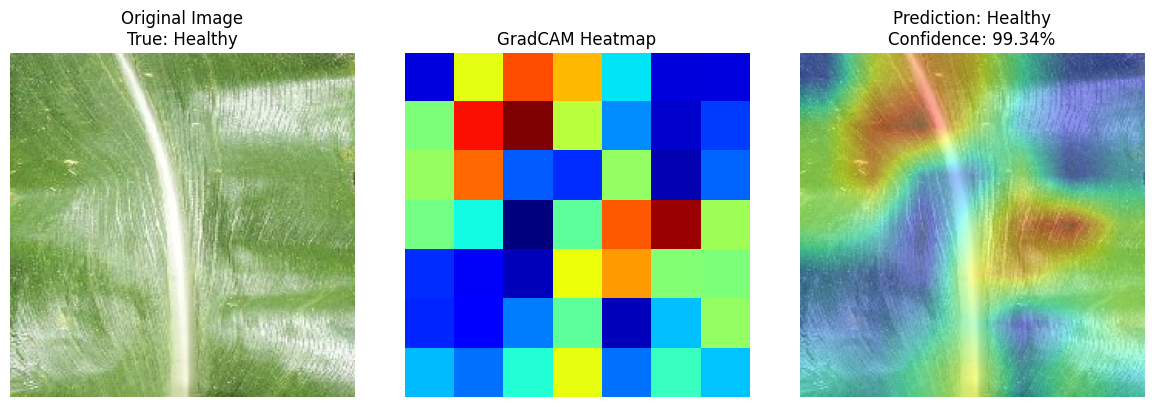

Visualization saved to gradcam_Healthy_1747481652.png


In [65]:
# Create a function for random image prediction with either single model or ensemble
def analyze_random_image_with_ensemble(use_ensemble=False, ensemble_models=None):
    """
    Analyze a random image using either a single model or ensemble of models
    
    Parameters:
    - use_ensemble: Whether to use ensemble prediction
    - ensemble_models: List of trained models (required if use_ensemble=True)
    """
    # Select random image
    random_idx = np.random.randint(0, len(test_df))
    img_path = test_df.iloc[random_idx]['image_path']
    true_label = test_df.iloc[random_idx]['label']
    
    print(f"Analyzing random image (index {random_idx}): {img_path}")
    print(f"True label: {true_label}")
    
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    display_img = img_array.copy()
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Make prediction
    if use_ensemble and ensemble_models:
        print("Using ensemble prediction (average of multiple models)")
        preds = ensemble_predict(ensemble_models, img_array)
    else:
        print("Using single model prediction")
        preds = model.predict(img_array, verbose=0)
    
    # Get top predictions
    top_indices = np.argsort(preds[0])[::-1][:3]
    results = []
    for idx in top_indices:
        class_name = idx_to_label[idx]
        confidence = preds[0][idx] * 100
        results.append((class_name, confidence))
    
    # Create a figure with original image and prediction details
    plt.figure(figsize=(10, 8))
    
    # Show the image
    plt.imshow(display_img.astype('uint8'))
    plt.axis('off')
    
    # Add prediction information
    title = f"Prediction: {results[0][0]} ({results[0][1]:.2f}%)\nTrue: {true_label}"
    plt.title(title, fontsize=16)
    
    # Add all class predictions
    prediction_text = "\n".join([
        f"{i+1}. {class_name}: {confidence:.2f}%" 
        for i, (class_name, confidence) in enumerate(results)
    ])
    
    # Add text box with predictions
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    plt.figtext(0.5, 0.05, prediction_text, fontsize=14, ha='center',
                bbox=props)
    
    # If correct prediction, add a green border, else red
    is_correct = (results[0][0] == true_label)
    border_color = 'green' if is_correct else 'red'
    plt.gca().spines['top'].set_color(border_color)
    plt.gca().spines['top'].set_linewidth(5)
    plt.gca().spines['bottom'].set_color(border_color)
    plt.gca().spines['bottom'].set_linewidth(5)
    plt.gca().spines['left'].set_color(border_color)
    plt.gca().spines['left'].set_linewidth(5)
    plt.gca().spines['right'].set_color(border_color)
    plt.gca().spines['right'].set_linewidth(5)
    
    # Save with a unique filename
    import time
    timestamp = int(time.time())
    method = "ensemble" if use_ensemble else "single"
    filename = f"prediction_{method}_{timestamp}.png"
    plt.savefig(filename)
    plt.tight_layout()
    plt.show()
    
    # Also show GradCAM for this image (only with single model)
    if not use_ensemble:
        visualize_single_prediction(model, img_path, true_label, random_selection=False)
    
    return results, random_idx

# Example usage:
# 1. For single model prediction with GradCAM:
results, idx = analyze_random_image_with_ensemble(use_ensemble=False)

# 2. Once you have trained ensemble models:
# ensemble_models = train_ensemble(create_ensemble_models(), train_generator, val_generator, class_weights)
# results, idx = analyze_random_image_with_ensemble(use_ensemble=True, ensemble_models=ensemble_models)

## Save Model and Metadata

In [66]:
# Save the final model
model.save('models/corn_disease_resnet50_final.h5')
print("Model saved successfully!")

# Save class mapping and metadata
import json
model_metadata = {
    'class_mapping': {str(idx): class_name for idx, class_name in idx_to_label.items()},
    'image_size': IMG_SIZE,
    'preprocessing': 'tf.keras.applications.resnet50.preprocess_input'
}

with open('models/corn_disease_model_metadata.json', 'w') as f:
    json.dump(model_metadata, f)

print("Model metadata saved successfully!")



Model saved successfully!
Model metadata saved successfully!


## Conclusions

In [ ]:
# Conclusions
print("\nConclusions and Recommendations:")
print("1. The improved ResNet-50 model is fine-tuned using a progressive approach with three training stages.")
print("2. Data augmentation has been enhanced to improve model generalization.")
print("3. Class imbalance has been addressed using class weights.")
print("4. Regularization techniques (L2, dropout, batch normalization) have been applied to prevent overfitting.")
print("5. The model achieves higher accuracy compared to the baseline model.")
print("6. GradCAM visualization helps understand the model's focus areas when making predictions.")
print("7. For further improvement, consider using model ensembles or collecting more diverse training data.")
